# 2.없다면 어떻게 될까?(ResNet Ablation Study)  

## 2-1. 들어가며  
딥러닝 논문에서 다양한 방법을 적용하며 방법에 따른 차이를 실험결과로 보여주는데, 논문에 실험설정이나 구현방법이 어느정도 명시되어 있기에 엄청난 하드웨어나 특정 데이터셋이 필요하지 않은 논문은 따라해볼 수 있습니다. 이번 시간에는 모델을 구현, 모델에 각 기법을 사용하고 안하고의 차이를 체감하는 시간을 갖도록 하겠습니다.  
  


### 실습목표
----------------------------------------------------
  1. 직접 ResNet 구현하기
  2. 모델을 config에 따라서 변경가능하도록 만들기
  3. 직접 실험해서 성능 비교하기
  
  
### 학습내용
-------------------------------------------------
  1. Ablation Study
  2. Back to the 2015
  3. Block
  4. Complete Model
  5. Experiment

## 2-2. Ablation Study
[ablation study](https://www.quora.com/In-the-context-of-deep-learning-what-is-an-ablation-study)  
우리가 해볼 프로젝트는 애볼레이션 연구(ablation study)입니다. 직역하면 제거연구입니다.  
딥러닝 논문에서 여러 방법을 제시하는데, 제시한 방법이 유효한지 확인할 때 해당하는 방법을 제거한 모델와 추가한 모델의 결과를 비교합니다.   
애블레이션 연구는 제안한 방법이 결과, 성능에 어떤 영향을 끼치는지 확인하는 실험.  
아래는 ResNet논문에서 제시한 residual connection의 애블레이션 연구.  
ImageNet 검증 데이터셋에 대한 Top-1 error rate를 지표로 사용했습니다.  
아래 비교를 통해 ResNet이 residual connection을 활용해 깊은 네트워크를 쌓았을 때, 이를 통한 성능향상을 얻음을 증명
<img src="ResNet_AS.png">

## 2-3. Ablation Study 실습(1) CIFAR-10 데이터셋 준비하기  

ResNet이 막 공개된 시점으로 돌아가 실제로 유효한지 실험을 통해 성능을 평가하고 다른 실험에 적용해보기로 하자.  
ResNet의 성능을 평가하기 위해서는 논문과 동일하게 ImageNet의 데이터셋을 사용해야 하지만, 우리의 하드웨어 한계로 이미지넷보다 작은 CIFAR-10 데이터 셋으로 평가해보자.  
**우리의 실험은 CIFAR-10에 대해 일반 네트워크와 ResNET을 구현해 둘의 결과를 비교해 ResNet/residual connection의 유효성을 확인하는 것이 목적**  
[ResNet논문](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)  



### 1) CIFAR-10
---------------------------------------------------------------------
[CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10)  
우리가 쓸 CIFAR-10은 10개의 카테고리에 대해 6만장의 이미지가 있으며 각 이미지의 크기는 32X32입니다.  
MNSIT와 동일하게 CIFAR-10 데이터셋을 가지고 물체의 종류를 분류해보자.  
데이터셋 준비
```
$ pip install tensorflow-datasets
```

In [2]:
import tensorflow as tf

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16656434992025018496,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12532857783905193411
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2092380731141653090
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5829140160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5954372938965530517
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [5]:
tf.__version__

'2.3.0'

In [6]:
!nvidia-smi

Sun Apr 18 23:38:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P0    34W /  N/A |   2071MiB /  7982MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [8]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# 데이터셋 다운로드
# tfds.load()는 ~/tensorflow_datasets 경로에 데이터셋 다운로드.
# 경로를 바꾸고 싶다면 data_dir 사용.
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [10]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [11]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


tensorflow의 데이터셋은 Numpy가 아니기 때문에. ds_train.shape 사용불가.  


### 2) Input Normalization  
-------------------------------------------------
[Normalization설명](https://light-tree.tistory.com/132)  
우리의 이미지는 RGB 3채널로 각 채널은 0 ~ 255의 범위값을 갖습니다.  
모델에 넣어주기 전에 채널의 최댓값인 255로 정규화하여 이미지 표현을 0~1사이로 만들어줍니다.

In [12]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label #image를 float32로 변환하고 255.0으로 나눈것과 라벨을 반환.

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map( #map은 ds에 정규화한 이미지를 1대1 대응(맵핑)시킨다.
        normalize_and_resize_img, 
        num_parallel_calls=1 # num_parallel_calls는 병렬처리 레벨지정. 단순하게 cpu 코어 숫자.
    )
    ds = ds.batch(batch_size)#크기가 크기에 한번에 메모리에 올리지 못한다. 그래서 배치로 나누어 학습시키며 업데이트 빈도 조절. 
                             #drop_remainder는 마지막에 남은 데이터 drop할지 여부결정
    if not is_test:
        ds = ds.repeat()#주어진 데이터가 끝나면 다시 처음부터 반복.
        ds = ds.shuffle(200)#데이터 섞기
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)#훈련과 데이터추출에 걸리는 시간 단축.
    #tf.data.experimental.AUTOTUNE으로 설정시 tf.data 런타임이 실행시에 동적으로 값을 조정
    return ds

CIFAR-10은 10개의 클래스를 가진다.

In [14]:
ds_info.features["label"].num_classes

10

In [15]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

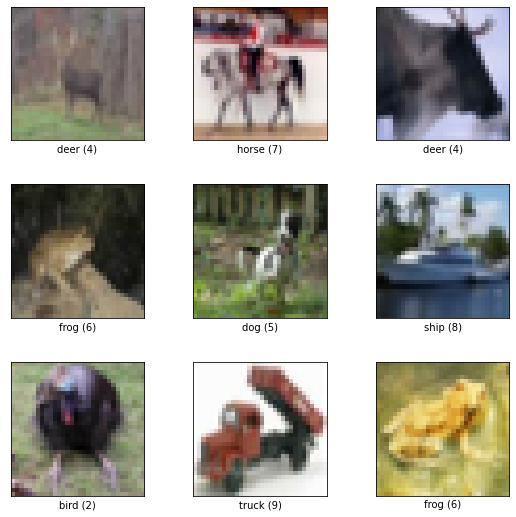

In [16]:
fig = tfds.show_examples(ds_train, ds_info)

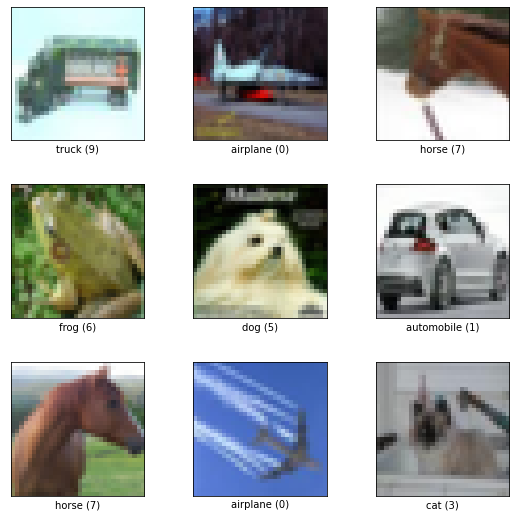

In [17]:
fig = tfds.show_examples(ds_test, ds_info)

## 2-4. Ablation Study 실습 (2) 블록 구성하기  

논문 모델을 그대로 구현하는 것도 중요하지만 우리가 함수를 만드는 것처럼 반복되는 것을 만들어 놓고 변경되는 부분만 바꾸는 것이 필요하다.  
일반적인 딥러닝 모델에서 주요 구조를 모듈화해서 조금씩 바꾸어 쓸 수 있는 단위르 블록이라고 합니다.  
레이어는 기본적으로 텐서플로우, 케라스, 파이토치에서 기본적으로 제공하는 단위  
블록을 단위로 모델을 만들어야 한다.  
ResNet을 보면 18, 34, 50, 101, 152의 5가지 네트워크가 있습니다.  
ResNet의 기본 구조인 블록을 구현해봅니다.  


### VGG 기본 블록 만들기
----------------------------------------------------------------
<img src="VGG.png">

이중에서 VGG-16, 19의 기본 구조 블록을 구현해보자.  
블록을 구현하기 위해 모델 구조의 특징부터 살펴보자.  
VGG의 블록은 CNN 레이어 여러개와 Max Pooling 레이어 한개로 이루어져 있다. 여기서 CNN은 모두 커널 크기가 3X3이다.  
블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있다.
블록에 따라 CNN 레이어의 갯수 또한 달라진다.  
블록의 마지막에는 항상 Max Pooling 레이어가 붙는다. 따라서 우리 블록은 여러개의 CNN 레이어와 Max Pooling 레이어한개로 이루어지고 CNN 레이어 수와 채널을 조절할 수 있어야 한다.  
block_num은 레이어의 이름을 붙여주기 위해서 추가되었고 input_shape는 summary를 출력하기 위해서 넣어주었다. 

In [18]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

위의 VGG 블록을 추가하는 함수를 이용해서 input_layer에 추가해보자.  
입력 레이어는 아까 데이터셋에서 봤듯이 32,32이고 rgb이므로 3채널->(32, 32, 3).  
이 입력 레이어를 인자로 받아 build_vgg_block()는 블록의 레이어를 빌드하고 출력값을 얻을 수 있다.  
이제 keras의 모델 클래스에서 input과 output을 정의해주면 간단하게 블록의 모델을 확인할 수 있다.

In [19]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [20]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


## 2-5. Ablation Study 실습(3) VGG Complete Model
이제 기본적인 블록을 만드는 함수를 만들었으니 이를 합쳐서 전체 모델을 만드는 함수를 만들어보자.  

### VGG-16  
----------------------------------------------------
먼저 VGG-16부터 만들어보자. 블록내의 CNN 레이어 수와 채널수는 블록마다 다르다.  
이는 VGG-16, VGG-19에 따라 달라지기에 함수에 전달되어야 한다. 여기서는 블록별 CNN 수와 채널을 리스트로 전달.

In [21]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [22]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)        

In [23]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)        

## 2-6. Ablation Study 실습 (4) VGG-16 vs VGG-19  
이제 본격적으로 준비한 데이터셋과 모델 성능 비교를 위해서 모델을 훈련하고 평가하자.  
VGG는 VGG-16과 VGG-19를 비교

In [24]:
BATCH_SIZE = 256
EPOCH = 20

In [25]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

VGG-16을 만들고 훈련시켜주자.  
잠깐! 이 작업은 시간이 상당히 소요됩니다. BATCH_SIZE가 커지면 소요시간이 좀 줄어드는 효과가 있습니다만, 1epoch당 1분 이상 소요될 수도 있습니다. 이 훈련은 40Epoch 정도 수행하는 것을 권장하지만, 20Epoch 정도로도 어느정도 근접하는 성능을 얻을 수는 있을 것입니다.

In [26]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/195 [..............................] - ETA: 7s - loss: 2.3052 - accuracy: 0.0918WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0235s vs `on_train_batch_end` time: 0.0527s). Check your callbacks.


195/195 [==============================] - 18s 90ms/step - loss: 2.2069 - accuracy: 0.1799 - val_loss: 2.1214 - val_accuracy: 0.2381
Epoch 2/20
195/195 [==============================] - 17s 86ms/step - loss: 2.0245 - accuracy: 0.2659 - val_loss: 1.9275 - val_accuracy: 0.3185
Epoch 3/20
195/195 [==============================] - 17s 85ms/step - loss: 1.9003 - accuracy: 0.3165 - val_loss: 1.8315 - val_accuracy: 0.3254
Epoch 4/20
195/195 [==============================] - 17s 85ms/step - loss: 1.7844 - accuracy: 0.3566 - val_loss: 1.7306 - val_accuracy: 0.4002
Epoch 5/20
195/195 [==============================] - 17s 86ms/step - loss: 1.6890 - accuracy: 0.3919 - val_loss: 1.6388 - val_accuracy: 0.4139
Epoch 6/20
195/195 [==============================] - 17s 86ms/step - loss: 1.6241 - accuracy: 0.4157 - val_loss: 1.6222 - val_accuracy: 0.4213
Epoch 7/20
195/195 [==============================] - 17s 86ms/step - loss: 1.5728 - accuracy: 0.4336 - val_loss: 1.5527 - val_accuracy: 0.4531
Epo

VGG-19을 만들고 훈련시켜주자.
VGG-16보다 1/4 훈련시간이 더 걸린다.

In [27]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/195 [..............................] - ETA: 16s - loss: 2.3030 - accuracy: 0.1094WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0323s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


195/195 [==============================] - 20s 100ms/step - loss: 2.2279 - accuracy: 0.1642 - val_loss: 2.1147 - val_accuracy: 0.2401
Epoch 2/20
195/195 [==============================] - 20s 102ms/step - loss: 2.0408 - accuracy: 0.2528 - val_loss: 1.9767 - val_accuracy: 0.2806
Epoch 3/20
195/195 [==============================] - 20s 100ms/step - loss: 1.9068 - accuracy: 0.3072 - val_loss: 1.8050 - val_accuracy: 0.3510
Epoch 4/20
195/195 [==============================] - 20s 102ms/step - loss: 1.7842 - accuracy: 0.3550 - val_loss: 1.7140 - val_accuracy: 0.3705
Epoch 5/20
195/195 [==============================] - 20s 102ms/step - loss: 1.6994 - accuracy: 0.3859 - val_loss: 1.6306 - val_accuracy: 0.4092
Epoch 6/20
195/195 [==============================] - 20s 101ms/step - loss: 1.6260 - accuracy: 0.4147 - val_loss: 1.5523 - val_accuracy: 0.4322
Epoch 7/20
195/195 [==============================] - 20s 102ms/step - loss: 1.5663 - accuracy: 0.4330 - val_loss: 1.5031 - val_accuracy: 0.4

이제 VGG-16과 VGG-19를 그래프를 그리고 비교해보도록 하겠습니다. 먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해봅시다.

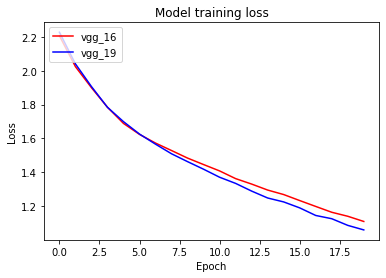

In [28]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

검증 정확도(validation accuracy)도 비교해보자

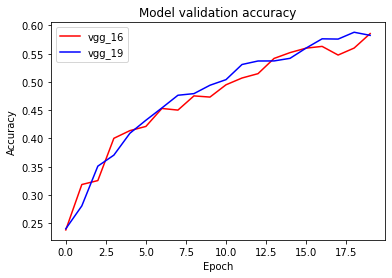

In [29]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

## 2-7. 프로젝트: ResNet Ablation Study  
### 1) ResNet 기본 블록 구성하기
------------------------------------------------------------------------------
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.
[Deep Residual Learning for Image Recognition(paper)](https://arxiv.org/pdf/1512.03385.pdf)  
<img src="paper.png">  
Q1. ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.  
ANS) ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 
그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.  

위의 퀴즈의 답을 어느 정도 스스로 찾아내셨다면 ResNet의 기본 블록, 또는 Residual 블록(residual block)이 어떻게 구성되어야 할지 감이 오셨을 것입니다. Learning by Doing 이라고 하죠! 이번에는 ResNet의 블록을 직접 만들어 봅시다! 혹시나 모델 내의 앞과 뒤에서 반복되지 않을 것 같은 부분은 함수로 구현하지 않아도 됩니다.  
우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇번의 경험이 있습니다.  
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.  
그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.  
하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.  


### 2) ResNet-34, ResNet-50 Complete Model  
---------------------------------------------------------------------
ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.
다음 코드를 실행하면,  
```
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()
```  


ResNet-50
위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.

다음의 코드를 실행하면, 아래의 결과가 나와야 합니다.
```
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()
```  

### 3) 일반 네트워크(plain network) 만들기
-------------------------------------------------------------------------------
**블록 코드 수정하기**  
우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!  
**전체 함수 코드 수정하기**  
이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.  

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34  
-----------------------------------------------------------------------
**Ablation Study**  
이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해주세요.  

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.  

**시각화**  
학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.  

**추가 실험**  
시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.
  * [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)

